In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from scipy import optimize,integrate

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])
# http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/

In [4]:
data = pd.DataFrame({"x":[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                           0.09,  0.19,  0.35,  0.4 ,  0.54,
                           0.42,  0.69,  0.2 ,  0.88,  0.03,
                           0.67,  0.42,  0.56,  0.14,  0.2  ],
                     "y":[ 0.33,  0.41, -0.22,  0.01, -0.05,
                          -0.05, -0.12,  0.26,  0.29,  0.39, 
                           0.31,  0.42, -0.01,  0.58, -0.2 ,
                           0.52,  0.15,  0.32, -0.13, -0.09 ],
                     "dy":[ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]})

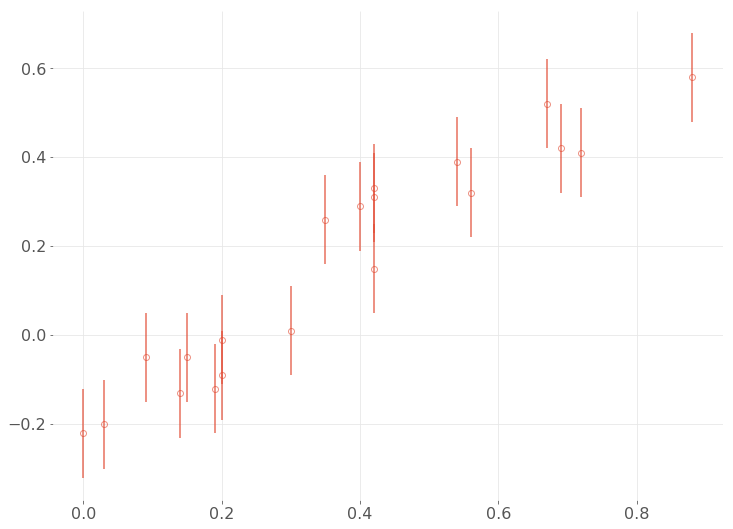

In [5]:
fig, ax = plt.subplots(figsize=(12,9))
ax.errorbar(data['x'], data['y'], yerr=data['dy'], ls='None', lw=2, marker='o', ms=6, mfc='None', alpha=0.6);

In [6]:
def polynomial_fit(theta, x):
    return sum(t * x**n for (n,t) in enumerate(theta)) # \sum_n \theta_n * x**n

def logL(theta,*, model, data):
    x,y,dy = data[:,0], data[:,1], data[:,2]
    y_fit  = model(theta, x)
    return sum(sp.stats.norm.logpdf(*args) for args in zip(y, y_fit, dy))/len(data)

def best_theta(degree, *, model, data):
    neg_logL   = lambda theta : -logL(theta, model=model, data=data)
    init_theta = (degree + 1) * [0]   # [\theta_0=0, \theta_1=0, .., \theta_n = 0]
    opt0       = optimize.minimize(neg_logL, init_theta, method='Nelder-Mead', options={'maxiter':2000, 'disp':0})
    opt1       = optimize.minimize(neg_logL, opt0['x'], method='L-BFGS-B', options={'maxiter':1000, 'disp':0})
    opt2       = optimize.minimize(neg_logL, opt1['x'], method='BFGS', options={'maxiter':500, 'disp':0})

    #rescale
    opt2['fun']= opt2['fun']*len(data)
    opt2['hess_inv'] = opt2['hess_inv']/len(data)
    
    print(f"n = {degree:3d}, logL = {-opt2['fun']:8.3e}, iter = {opt2['nit']:4d}, status = {opt2['message']}")
    return opt2

In [7]:
thetas  = [best_theta(n, model=polynomial_fit, data=data.to_numpy()) for n in range(1,10)]

n =   1, logL = 2.201e+01, iter =    2, status = Optimization terminated successfully.
n =   2, logL = 2.294e+01, iter =    3, status = Optimization terminated successfully.
n =   3, logL = 2.318e+01, iter =    2, status = Optimization terminated successfully.
n =   4, logL = 2.380e+01, iter =    0, status = Optimization terminated successfully.
n =   5, logL = 2.406e+01, iter =    1, status = Optimization terminated successfully.
n =   6, logL = 2.437e+01, iter =   66, status = Optimization terminated successfully.
n =   7, logL = 2.432e+01, iter =   56, status = Optimization terminated successfully.
n =   8, logL = 2.426e+01, iter =   54, status = Optimization terminated successfully.
n =   9, logL = 2.469e+01, iter =   92, status = Optimization terminated successfully.


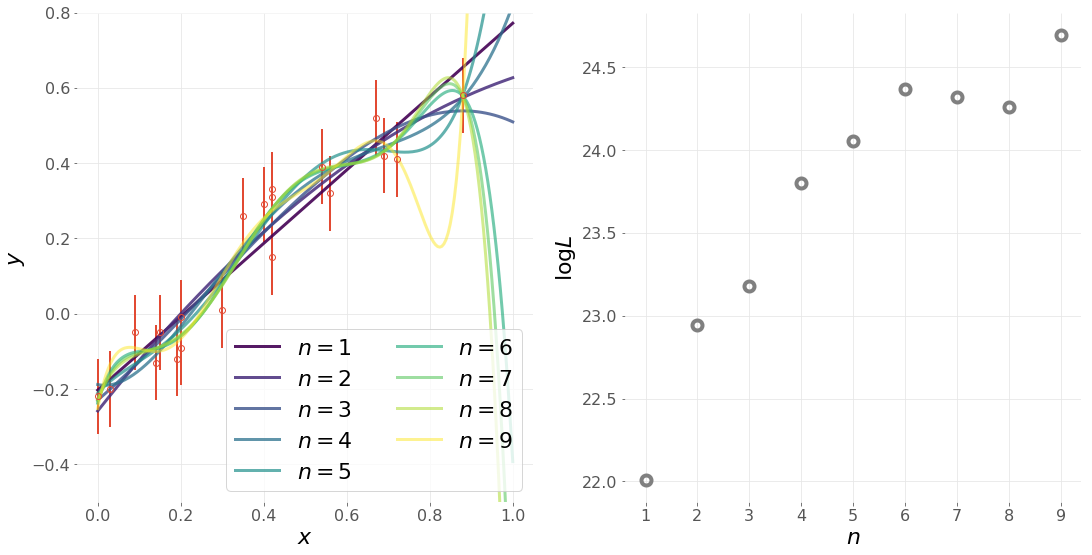

In [13]:
fig, [ax,bx] = plt.subplots(figsize=(18,9),ncols=2)

x = np.linspace(0, 1, num=200)
colors = mpl.cm.viridis(np.linspace(0,1,len(thetas)))
for n,theta in enumerate(thetas):
    ax.plot(x, polynomial_fit(theta['x'], x), label=f"$n={n+1}$", color=colors[n], alpha=0.9-0.05*n)
ax.errorbar(data['x'], data['y'], yerr=data['dy'], ls='None', lw=2, marker='o', ms=6, mfc='None', color='C0', label=None)
ax.set_ylim(-0.5, 0.8)
ax.legend(fontsize=(22),ncol=2,loc=4)

bx.plot(range(1,len(thetas)+1), [-theta['fun'] for theta in thetas], marker='o', color='gray', mfc='None', mew=4, ls='None')
for xx,l in zip([ax,bx], [r'$x$', r'$n$']):
    xx.set_xlabel(l, fontsize=22)
for xx,l in zip([ax,bx], [r'$y$', r'$\log L$']):
    xx.set_ylabel(l, fontsize=22)

Let's say we have to decide between two models, $n=1$ and $n=2$, for a linear and quadratic fit to the data.
How to decide between them?

\begin{align}
O_{21} &\equiv \frac{P(M_2 | D)}{P(M_1 | D)} \\
&= \frac{P(D | M_2)}{P(D|M_1)}\cdot \frac{P(M_2)}{P(M_1)}
\end{align}

We can compute the likelihood $P(D|M_i)$ by marginalizing over the model parameters $\theta_i$

\begin{align}
P(D | M_i) &= \int\mathrm{d}\theta_i\, P(D, \theta_i | M_i) \\
&= \int\mathrm{d}\theta_i\, P(D | \theta_i, M_i) \cdot P(\theta_i | M_i)
\end{align}

Evaluating this integral by brute force will only be possible for very simple models (low dimensions).
Note that the integrand is closely related to the posterior $P(\theta_i | D, M_i)$ we calculated when considering model fitting (instead of model selection). Recall that

\begin{align}
P(\theta | D, M) &= \frac{P(D | \theta, M) P(\theta | M)}{P(D | M)}
\end{align}

While MCMC allows us to compute $P(\theta | D, M)$, drawing samples following this distribution, it cannot be used to calculate the normalization factor $P(D | M)$ ! 

For this, other methods are required...

Anyway, let's do MCMC to see what the optimal parameters look like for each model.

In [14]:
xval  = data.x.to_numpy()
yval  = data.y.to_numpy()
dyval = data.dy.to_numpy()
with pm.Model() as linear_model: # y = a_1 x + a_0
    θ = pm.Uniform('θ', lower=-5.0, upper=5.0, shape=(2))
    y = pm.Normal('y', mu = θ[0] + θ[1]*xval, sd = dyval, observed = yval)
with pm.Model() as quadratic_model: # y = a x^2 + b x + c
    θ = pm.Uniform('θ', lower=-5.0, upper=5.0, shape=(3))
    y = pm.Normal('y', mu = θ[0] + θ[1]*xval + θ[2]*xval**2, sd = dyval, observed = yval)

In [15]:
with linear_model:
    trace1 = pm.sample(5000, tune = 20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:27<00:00, 3629.63draws/s]
The acceptance probability does not match the target. It is 0.7100650609669739, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
with quadratic_model:
    trace2 = pm.sample(5000, tune=20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:14<00:00, 1343.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [17]:
labels = [f'$\\theta_{i}$' for i in range(len(thetas))]

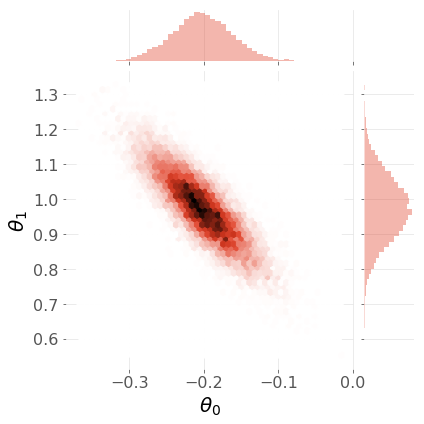

In [18]:
df1 = pd.DataFrame(trace1['θ'], columns=labels[:2])
jointplot = sns.jointplot(labels[0], labels[1], data=df1, kind='hex')

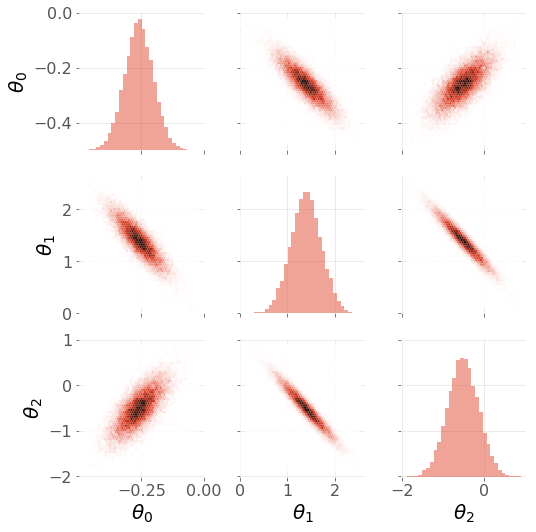

In [19]:
cmap = jointplot.ax_joint.collections[0].get_cmap()
df2 = pd.DataFrame(trace2['θ'], columns=labels[:3])
grid = sns.PairGrid(df2)
grid.map_diag(plt.hist, bins=30, alpha=0.5)
grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

Let's recall what exactly it is we need to calculate, the likelihood of the data $D$ for each of the models $M_i$

\begin{align}
P(D | M_i) 
&= \int\mathrm{d}\theta_i\, P(D | \theta_i, M_i) \cdot P(\theta_i | M_i) \\
&=\int\mathrm{d}\theta_i\, \frac{1}{\left(\theta_{\text{max}} - \theta_{\text{min}}\right)^{n_i}}\prod_i\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left[-\frac{\left(y_i - f_M(x_i)\right)^2}{2 \sigma_i^2}\right]} \\
&= \int\mathrm{d}\theta_i\, \exp{\bigg[-n_i\log{\left(\theta_{\text{max}} - \theta_{\text{min}}\right)} - \frac{1}{2}\sum_i\frac{\left(y_i - f(x_i)\right)^2}{\sigma_i^2} - \sum_i\frac{1}{2}\log{2\pi\sigma_i^2}\bigg]}
\end{align}

For what follows, we assume $\theta_\text{max} = -\theta_\text{min} = 5$
\begin{align}
P(\theta_i | M_i) &= \begin{cases}
10^{-n_i} & \textrm{if}\; |\theta_{i,j}| < 5 \; (\textrm{for all }j=1\ldots,n_i) \\
0 & \text{otherwise}
\end{cases}
\end{align}

In [106]:
theta_max = 5
def log_prior(theta):
    if np.any(np.abs(theta)) > theta_max:
        return -np.inf # log(0)
    else:
        # note the typo in jakevdp's blog
        return -len(theta)*np.log(2*theta_max) 

def log_likelihood(theta, data=data):
    x,y,dy = data['x'], data['y'], data['dy']
    return -0.5*np.sum((yval - polynomial_fit(theta, xval))**2/dyval**2 + np.log(2.0*np.pi*dyval**2))

def log_posterior(theta, data = data):
    return log_prior(theta) + log_likelihood(theta, data)

def integrate_posterior1(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])
def integrate_posterior2(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

In [107]:
xlim, ylim = zip(trace1[θ].min(axis=0), trace1[θ].max(axis=0))
%time Z1, err_Z1 = integrate_posterior1(log_posterior, xlim, ylim)
print(f"Z1 = {Z1} +/- {err_Z1}")

xlim, ylim, zlim = zip(trace2[θ].min(axis=0), trace2[θ].max(axis=0))
%time Z2, err_Z2 = integrate_posterior2(log_posterior, xlim, ylim, zlim)
print(f"Z2 = {Z2} +/- {err_Z2}")

CPU times: user 328 ms, sys: 652 µs, total: 328 ms
Wall time: 329 ms
Z1 = 469472.0123384044 +/- 0.011982000479540122
CPU times: user 1min 9s, sys: 233 ms, total: 1min 10s
Wall time: 1min 10s
Z2 = 111092.6768411902 +/- 0.01768120457745681


\begin{align}
O_{21} &\equiv \frac{P(M_2 | D)}{P(M_1 | D)} \\
&= \frac{P(D | M_2)}{P(D|M_1)}\cdot \frac{P(M_2)}{P(M_1)}
\end{align}

In [105]:
odds = Z2/Z1
print(f"Bayes factor = {odds:.3f}")
print(f"Evidence     = {10*np.log10(odds):.0f}")

Bayes factor = 0.394
Evidence     = -4


In [102]:
evidence = pd.DataFrame({'p':np.array([1/2, 2/3, 4/5, 10/11, 100/101, 0.999, 0.9999])})
evidence['O'] = evidence['p']/(1.0 - evidence['p'])
evidence['10 log_10(O)'] = 10.0*np.log10(evidence['O'])
evidence.style.format({'p': "{:.4g}", '10 log_10(O)': "{:.0f}", 'O':"{0:.0f}:1"})

,p,O,10 log_10(O)
0,0.5,1:1,0
1,0.6667,2:1,3
2,0.8,4:1,6
3,0.9091,10:1,10
4,0.9901,100:1,20
5,0.999,999:1,30
6,0.9999,9999:1,40


[Bayes Factors](http://links.jstor.org/sici?sici=0162-1459%28199506%2990%3A430%3C773%3ABF%3E2.0.CO%3B2-8)

Following Kass and Raftery, we have the following rule of thumb for how to interpret the evidence $10 \log_{10}(O)$
\begin{align}
0 \le O \le 5 & \qquad\textrm{Not worth more than a bare mention} \\
5 < O \le 10 & \qquad\textrm{Substantial} \\
10 < O \le 20 & \qquad\textrm{Strong} \\
20 < O &\qquad\textrm{Decisive}
\end{align}